In [1]:
%load_ext lab_black
%load_ext autotime
import pandas as pd
import numpy as np

time: 435 ms (started: 2023-07-23 10:36:45 -07:00)


A set of images of a face under different rotations and lighting conditions, used as a dataset in Isomap. Unfortunately, it’s no longer available at the Stanford website, but we can rescue it from the mists of time via the [Wayback Machine](https://web.archive.org/web/20150922051706/http://isomap.stanford.edu/face_data.mat.Z).

To make things even more complicated, this file has been Z-compressed, which means you would need to uncompress this with e.g. `uncompress` (on Linux) or 7-zip (on Windows). There are some python packages that can do this for you on PyPI including [unlzw](https://pypi.org/project/unlzw/) and [unlzw3](https://pypi.org/project/unlzw3/) and [ncompress](https://pypi.org/project/ncompress/) (thank you to this [stack overflow page](https://stackoverflow.com/q/32921263/4096483)). I chose `ncompress` pretty much arbitrarily. I leaned heavily on [a gist](https://gist.github.com/jlmelville/339dfeb80c3e836e887d70a37679b244) for R to remember how to do this.

In [2]:
from io import BytesIO

import ncompress
import requests
import scipy.io

req = requests.get(
    "https://web.archive.org/web/20150922051706/http://isomap.stanford.edu:80/face_data.mat.Z",
    timeout=10,
)
faces_data = scipy.io.loadmat(
    BytesIO(ncompress.decompress(req.content)), squeeze_me=True, struct_as_record=False
)

# Equivalent with ulzw3 if ncompress doesn't work out for you:
# import unlzw3
# faces_data = scipy.io.loadmat(
#     BytesIO(unlzw3.unlzw(req.content)), squeeze_me=True, struct_as_record=False
# )

time: 2.13 s (started: 2023-07-23 10:36:45 -07:00)


In [3]:
faces_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'lights', 'images', 'image_pcs', 'poses'])

time: 7.26 ms (started: 2023-07-23 10:36:47 -07:00)


In [4]:
faces_data["images"].shape

(4096, 698)

time: 9.63 ms (started: 2023-07-23 10:36:47 -07:00)


There are 698 images, each being 64 x 64 pixels in size. The data is stored by column, not row.

## View a face

In [5]:
import matplotlib.pyplot as plt


def show_face(faces, idx):
    nx = 64
    ny = nx
    plt.axis("off")
    plt.imshow(
        faces[:, idx].reshape((nx, ny)).T,
        cmap=plt.cm.gray,
        interpolation="nearest",
        vmin=0,
        vmax=1,
    )

time: 366 ms (started: 2023-07-23 10:36:47 -07:00)


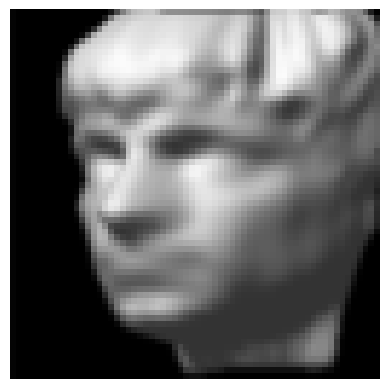

time: 95.6 ms (started: 2023-07-23 10:36:48 -07:00)


In [6]:
show_face(faces_data["images"], 0)

## Data pipeline

Data needs to be transposed to have each image in the rows:

In [7]:
data = faces_data["images"].T

time: 999 µs (started: 2023-07-23 10:36:48 -07:00)


The `poses` data relates to the angle of the head in each image. Using the terminology in Figure 1 of the Isomap paper, the first column encodes "left-right" pose, and the second column encodes "up-down" pose. Either could be used to color the manifold.

In [8]:
faces_data["poses"].shape

(2, 698)

time: 5.11 ms (started: 2023-07-23 10:36:48 -07:00)


Left-right examples. Increasing the value of this feature goes from left to right (i.e. increasing x-axis) in Figure 1:

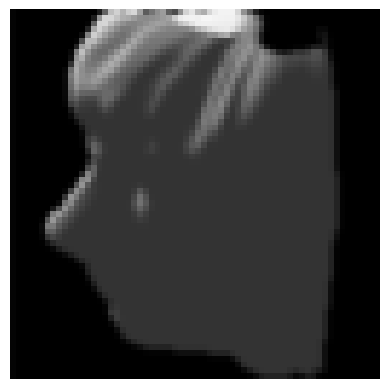

time: 69.2 ms (started: 2023-07-23 10:36:48 -07:00)


In [9]:
show_face(faces_data["images"], np.argmin(faces_data["poses"][0]))

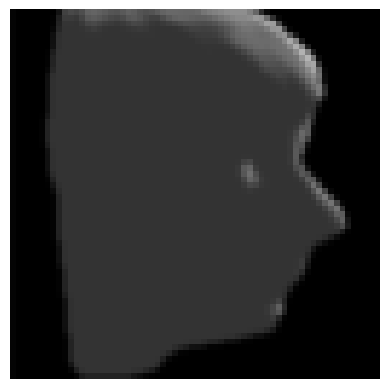

time: 62.2 ms (started: 2023-07-23 10:36:48 -07:00)


In [10]:
show_face(faces_data["images"], np.argmax(faces_data["poses"][0]))

And up-down examples. Increasing the value of this feature goes from top to bottom (i.e. decreasing y-axis) in Figure 1:

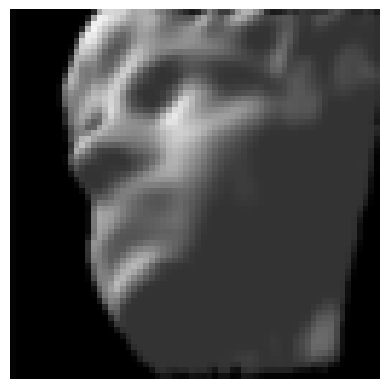

time: 56.4 ms (started: 2023-07-23 10:36:48 -07:00)


In [11]:
show_face(faces_data["images"], np.argmin(faces_data["poses"][1]))

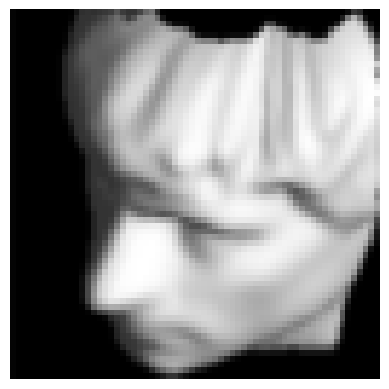

time: 60 ms (started: 2023-07-23 10:36:48 -07:00)


In [12]:
show_face(faces_data["images"], np.argmax(faces_data["poses"][1]))

The `lights` data is encoded in Figure 1 as a horizontal slider under the example images. Increasing values of this data encode the lighting (and the position of the slider bar in the figure) going from left to right:

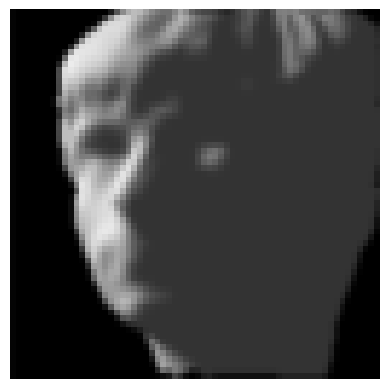

time: 69.6 ms (started: 2023-07-23 10:36:48 -07:00)


In [13]:
show_face(faces_data["images"], np.argmin(faces_data["lights"]))

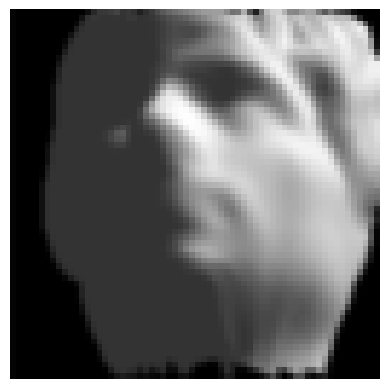

time: 61.3 ms (started: 2023-07-23 10:36:48 -07:00)


In [14]:
show_face(faces_data["images"], np.argmax(faces_data["lights"]))

In [15]:
target = pd.DataFrame(
    {
        "lighting-direction": faces_data["lights"],
        "left-right": faces_data["poses"][0],
        "up-down": faces_data["poses"][1],
    }
)

time: 2.53 ms (started: 2023-07-23 10:36:48 -07:00)


In [16]:
target

,lighting-direction,left-right,up-down
0,183.086157,-32.119184,-0.791317
1,199.015147,29.043989,-1.963342
2,184.105388,-28.112839,0.834203
3,139.357752,59.262967,-9.700989
4,134.411966,-42.009602,9.401733
...,...,...,...
693,199.574681,-34.086428,5.489509
694,189.803622,-48.328393,9.410430
695,226.931894,69.475295,1.254550
696,130.380497,24.340441,-5.578956


time: 16.5 ms (started: 2023-07-23 10:36:48 -07:00)


In [17]:
from drnb.io.pipeline import create_default_pipeline

data_result = create_default_pipeline(check_for_duplicates=True).run(
    "isofaces",
    data=data,
    target=target,
    tags=["small", "synthetic", "image", "isomap"],
    verbose=True,
)

[10:36:53] INFO     Requesting one extra neighbor to account for self-neighbor                      ]8;id=657678;file:///home/james/dev/drnb/src/drnb/neighbors/__init__.py\__init__.py]8;;\:]8;id=327080;file:///home/james/dev/drnb/src/drnb/neighbors/__init__.py#576\576]8;;\

           INFO     Initial data shape: (698, 4096)                                                  ]8;id=983166;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=249105;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#77\77]8;;\

           INFO     Keeping all columns                                                            ]8;id=722639;file:///home/james/dev/drnb/src/drnb/preprocess.py\preprocess.py]8;;\:]8;id=78823;file:///home/james/dev/drnb/src/drnb/preprocess.py#73\73]8;;\

           INFO     Data shape after filtering columns: (698, 4096)                                 ]8;id=8898;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=911435;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#148\148]8;;\

           INFO     Removing rows with NAs                                                          ]8;id=281172;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=709838;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#132\132]8;;\

           INFO     Data shape after filtering NAs: (698, 4096)                                     ]8;id=951152;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=488754;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#143\143]8;;\

           INFO     Checked for duplicates: found 0                                                 ]8;id=444860;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=440481;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#155\155]8;;\

           INFO     No scaling                                                                     ]8;id=406770;file:///home/james/dev/drnb/src/drnb/preprocess.py\preprocess.py]8;;\:]8;id=893583;file:///home/james/dev/drnb/src/drnb/preprocess.py#28\28]8;;\

           INFO     Converting to numpy with {'dtype': 'float32', 'layout': 'c'}                    ]8;id=198697;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=353298;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#160\160]8;;\

           INFO     Writing data for isofaces                                                       ]8;id=626557;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=718822;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#228\228]8;;\

[10:36:55] INFO     Processing target with initial shape (698, 3)                                   ]8;id=878619;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=785271;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#199\199]8;;\

           INFO     Keeping all columns                                                            ]8;id=64350;file:///home/james/dev/drnb/src/drnb/preprocess.py\preprocess.py]8;;\:]8;id=374853;file:///home/james/dev/drnb/src/drnb/preprocess.py#73\73]8;;\

           INFO     Writing target for isofaces                                                     ]8;id=985228;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=614128;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#228\228]8;;\

           INFO     Calculating nearest neighbors                                                   ]8;id=130974;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=484921;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#243\243]8;;\

           INFO     Loading faiss with AVX2 support.                                                   ]8;id=587472;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss-1.7.4-py3.10.egg/faiss/loader.py\loader.py]8;;\:]8;id=382356;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss-1.7.4-py3.10.egg/faiss/loader.py#54\54]8;;\

[10:36:56] INFO     Successfully loaded faiss with AVX2 support.                                       ]8;id=463151;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss-1.7.4-py3.10.egg/faiss/loader.py\loader.py]8;;\:]8;id=908852;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss-1.7.4-py3.10.egg/faiss/loader.py#56\56]8;;\

           INFO     Using 'faiss' to find nearest neighbors                                          ]8;id=58332;file:///home/james/dev/drnb/src/drnb/neighbors/__init__.py\__init__.py]8;;\:]8;id=468615;file:///home/james/dev/drnb/src/drnb/neighbors/__init__.py#83\83]8;;\

           INFO     Finding 151 neighbors using faiss with euclidean metric and params: {}           ]8;id=573521;file:///home/james/dev/drnb/src/drnb/neighbors/__init__.py\__init__.py]8;;\:]8;id=284976;file:///home/james/dev/drnb/src/drnb/neighbors/__init__.py#96\96]8;;\

[10:36:57] INFO     Writing numpy format to nn/isofaces.16.euclidean.exact.faiss.idx.npy            ]8;id=801033;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=777212;file:///home/james/dev/drnb/src/drnb/io/__init__.py#306\306]8;;\

[10:36:58] INFO     Writing csv format to nn/isofaces.16.euclidean.exact.faiss.idx.csv              ]8;id=208667;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=502743;file:///home/james/dev/drnb/src/drnb/io/__init__.py#283\283]8;;\

           INFO     Writing numpy format to nn/isofaces.16.euclidean.exact.faiss.dist.npy           ]8;id=121092;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=423162;file:///home/james/dev/drnb/src/drnb/io/__init__.py#306\306]8;;\

           INFO     Writing csv format to nn/isofaces.16.euclidean.exact.faiss.dist.csv             ]8;id=703878;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=622567;file:///home/james/dev/drnb/src/drnb/io/__init__.py#283\283]8;;\

           INFO     Writing numpy format to nn/isofaces.51.euclidean.exact.faiss.idx.npy            ]8;id=636957;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=288257;file:///home/james/dev/drnb/src/drnb/io/__init__.py#306\306]8;;\

           INFO     Writing csv format to nn/isofaces.51.euclidean.exact.faiss.idx.csv              ]8;id=909601;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=94017;file:///home/james/dev/drnb/src/drnb/io/__init__.py#283\283]8;;\

           INFO     Writing numpy format to nn/isofaces.51.euclidean.exact.faiss.dist.npy           ]8;id=460346;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=731086;file:///home/james/dev/drnb/src/drnb/io/__init__.py#306\306]8;;\

           INFO     Writing csv format to nn/isofaces.51.euclidean.exact.faiss.dist.csv             ]8;id=416720;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=483929;file:///home/james/dev/drnb/src/drnb/io/__init__.py#283\283]8;;\

           INFO     Writing numpy format to nn/isofaces.151.euclidean.exact.faiss.idx.npy           ]8;id=783744;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=772912;file:///home/james/dev/drnb/src/drnb/io/__init__.py#306\306]8;;\

           INFO     Writing csv format to nn/isofaces.151.euclidean.exact.faiss.idx.csv             ]8;id=304808;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=654822;file:///home/james/dev/drnb/src/drnb/io/__init__.py#283\283]8;;\

           INFO     Writing numpy format to nn/isofaces.151.euclidean.exact.faiss.dist.npy          ]8;id=48894;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=94880;file:///home/james/dev/drnb/src/drnb/io/__init__.py#306\306]8;;\

           INFO     Writing csv format to nn/isofaces.151.euclidean.exact.faiss.dist.csv            ]8;id=110873;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=361481;file:///home/james/dev/drnb/src/drnb/io/__init__.py#283\283]8;;\

[10:36:59] INFO     Calculating triplets                                                            ]8;id=378883;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=372834;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#254\254]8;;\

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


[10:37:00] INFO     Writing csv format to triplets/isofaces.5.1337.idx.csv                          ]8;id=162983;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=669584;file:///home/james/dev/drnb/src/drnb/io/__init__.py#283\283]8;;\

           INFO     Writing csv format to triplets/isofaces.5.1337.euclidean.csv                    ]8;id=64484;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=869802;file:///home/james/dev/drnb/src/drnb/io/__init__.py#283\283]8;;\

           INFO     Writing numpy format to triplets/isofaces.5.1337.idx.npy                        ]8;id=982189;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=652012;file:///home/james/dev/drnb/src/drnb/io/__init__.py#306\306]8;;\

           INFO     Writing numpy format to triplets/isofaces.5.1337.euclidean.npy                  ]8;id=464278;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=35292;file:///home/james/dev/drnb/src/drnb/io/__init__.py#306\306]8;;\

           INFO     Writing pipeline result for isofaces                                            ]8;id=414315;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=528887;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#125\125]8;;\

time: 11.4 s (started: 2023-07-23 10:36:48 -07:00)
